## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Class Imbalance in Credit Scoring</span> </center>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import pandas as pd

In [2]:
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

In [3]:
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Virgil GS"

In [4]:
from sklearn.model_selection import train_test_split

features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
    "balance",
]

target = "is_bad"

X = dataset[features + [target]].copy()
y = X.pop("is_bad")

ix_train, ix_test = train_test_split(X.index, test_size=0.3, random_state=62)

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Class-imbalanced sampling</span>

In [5]:
import pandas as pd


def create_imbalanced_datasets_with_prefix(
    X, y, fractions, prefix="dataset_", random_state=62
):
    dataset_bads = pd.concat([X[y == 1], y[y == 1]], axis=1)
    dataset_goods = pd.concat([X[y == 0], y[y == 0]], axis=1)

    concatenated_results = pd.DataFrame()

    for fraction in fractions:
        subsample = pd.concat(
            [
                dataset_bads.sample(frac=fraction, random_state=random_state),
                dataset_goods.sample(frac=(1 - fraction), random_state=random_state),
            ]
        )

        default_rate = subsample["is_bad"].mean().round(4)
        dataset_name = f"{prefix}{default_rate:.0%}"
        subsample["name"] = f"{prefix}{default_rate:.0%}"
        concatenated_results = pd.concat([concatenated_results, subsample], axis=0)

    return pd.DataFrame(concatenated_results)


# Define fractions to rebalance the dataset
fractions = [0.09, 0.19, 0.35, 0.49, 0.61, 0.69]
datasets = create_imbalanced_datasets_with_prefix(X, y, fractions, prefix="")

In [6]:
# Keep the hold-out set
condition = X.loc[ix_test].index
unique_dataset_names = datasets["name"].unique()
training_datasets = pd.DataFrame()

for unique_dataset in unique_dataset_names:
    new_samples = datasets[
        (datasets["name"] == unique_dataset) & ~datasets.index.isin(condition)
    ]
    training_datasets = pd.concat([training_datasets, new_samples], axis=0)

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Training</span>

In [7]:
import xgboost as xgb

base_classifier = xgb.XGBClassifier()
classifiers = {}

for sample_name in training_datasets["name"].unique():
    sample = training_datasets[training_datasets["name"] == sample_name]

    X_train = sample[features]
    y_train = sample[target]

    classifier = xgb.XGBClassifier()
    classifier.fit(X_train, y_train)

    # Store the classifier in the dictionary
    classifiers[sample_name] = classifier

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Evaluation of imbalance</span>

In [8]:
holdout_set = pd.concat([X.loc[ix_test], y.loc[ix_test]], axis=1)

holdout_set = pd.concat(
    [
        holdout_set[holdout_set["is_bad"] == 1].sample(frac=1.0, random_state=62),
        holdout_set[holdout_set["is_bad"] == 0].sample(frac=1.0, random_state=62),
    ]
)

print(holdout_set["is_bad"].mean())

0.09266666666666666


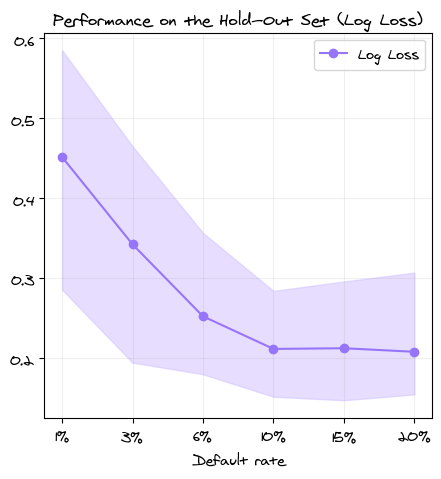

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from matplotlib import pyplot as plt

# Store the results in a dictionary
eval_results = {"classifier": [], "log_loss": [], "ci_lower": [], "ci_upper": []}

# Set up KFold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for clf_name, classifier in classifiers.items():
    eval_results["classifier"].append(clf_name)

    # Perform custom k-fold sampling and calculate log-loss scores
    log_loss_scores = []

    for _, fold_ix in kf.split(holdout_set[features], holdout_set[target]):
        X_trn = X.loc[ix_test].iloc[fold_ix]
        y_trn = y.loc[ix_test].iloc[fold_ix]

        # Calculate log-loss for the current bootstrap sample
        y_pred_proba = classifier.predict_proba(X_trn)
        current_log_loss = log_loss(y_trn, y_pred_proba)
        log_loss_scores.append(current_log_loss)

    # Calculate mean and standard deviation of log-loss scores
    mean_log_loss = np.mean(log_loss_scores)
    std_log_loss = np.std(log_loss_scores)

    ci_lower = min(log_loss_scores)
    ci_upper = max(log_loss_scores)

    eval_results["ci_lower"].append(ci_lower)
    eval_results["ci_upper"].append(ci_upper)
    eval_results["log_loss"].append(mean_log_loss)

figure = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(
    eval_results["classifier"],
    eval_results["log_loss"],
    marker="o",
    color="#9775fa",
    label="Log Loss",
)
plt.fill_between(
    eval_results["classifier"],
    eval_results["ci_lower"],
    eval_results["ci_upper"],
    color="#d0bfff",
    alpha=0.5,
)

# Customize the plot
plt.xlabel("Default rate")
plt.title("Performance on the Hold-Out Set (Log Loss)")
plt.xticks(rotation=0)
plt.grid(alpha=0.2)
plt.legend()
plt.show()

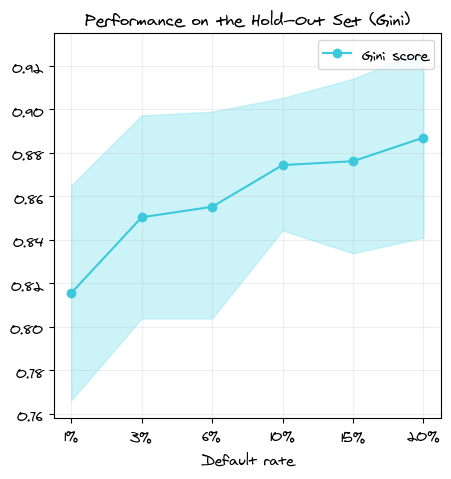

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

# Store the results in a dictionary
eval_results = {"classifier": [], "gini": [], "ci_lower": [], "ci_upper": []}

# Set up KFold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for clf_name, classifier in classifiers.items():
    eval_results["classifier"].append(clf_name)

    # Perform cross-validation and calculate gini scores
    gini_scores = []

    for _, fold_ix in kf.split(holdout_set[features], holdout_set[target]):
        X_trn = X.loc[ix_test].iloc[fold_ix]
        y_trn = y.loc[ix_test].iloc[fold_ix]

        # Calculate log-loss for the current sample
        y_pred_proba = classifier.predict_proba(X_trn)[:, 1]
        current_gini = roc_auc_score(y_trn, y_pred_proba) * 2 - 1  # type: ignore
        gini_scores.append(current_gini)

    # Calculate mean and standard deviation of gini scores
    mean_gini = np.mean(gini_scores)
    std_gini = np.std(gini_scores)

    ci_lower = min(gini_scores)
    ci_upper = max(gini_scores)

    eval_results["ci_lower"].append(ci_lower)
    eval_results["ci_upper"].append(ci_upper)
    eval_results["gini"].append(mean_gini)

figure = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(
    eval_results["classifier"],
    eval_results["gini"],
    marker="o",
    color="#3bc9db",
    label="Gini score",
)
plt.fill_between(
    eval_results["classifier"],
    eval_results["ci_lower"],
    eval_results["ci_upper"],
    color="#99e9f2",
    alpha=0.5,
)

# Customize the plot
plt.xlabel("Default rate")
plt.title("Performance on the Hold-Out Set (Gini)")
plt.xticks(rotation=0)
plt.grid(alpha=0.2)
plt.legend()
plt.show()

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Evaluation of absolute default numbers</span>

In [11]:
import pandas as pd


def create_rare_event_datasets_with_prefix(
    X, y, fractions, prefix="dataset_", random_state=62
):
    dataset_bads = pd.concat([X[y == 1], y[y == 1]], axis=1)
    dataset_goods = pd.concat([X[y == 0], y[y == 0]], axis=1)

    concatenated_results = pd.DataFrame()

    for absolute_count in absolute_counts:
        subsample = pd.concat(
            [
                dataset_bads.sample(n=absolute_count, random_state=random_state),
                dataset_goods.sample(frac=1, random_state=random_state),
            ]
        )

        default_count = subsample["is_bad"].sum().round(4)
        # dataset_name = f"{prefix}{default_count:.0f}"
        subsample["name"] = f"{prefix}{default_count:.0f}"
        concatenated_results = pd.concat([concatenated_results, subsample], axis=0)

    return pd.DataFrame(concatenated_results)


# Define absolute counts to rebalance the dataset
absolute_counts = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
datasets = create_rare_event_datasets_with_prefix(X, y, absolute_counts, prefix="")

In [12]:
# Keep the hold-out set
condition = X.loc[ix_test].index
unique_dataset_names = datasets["name"].unique()
training_datasets = pd.DataFrame()

for unique_dataset in unique_dataset_names:
    new_samples = datasets[
        (datasets["name"] == unique_dataset) & ~datasets.index.isin(condition)
    ]
    training_datasets = pd.concat([training_datasets, new_samples], axis=0)

In [13]:
import xgboost as xgb

base_classifier = xgb.XGBClassifier()
classifiers = {}

for sample_name in training_datasets["name"].unique():
    sample = training_datasets[training_datasets["name"] == sample_name]

    X_train = sample[features]
    y_train = sample[target]

    classifier = xgb.XGBClassifier()
    classifier.fit(X_train, y_train)

    # Store the classifier in the dictionary
    classifiers[sample_name] = classifier

In [14]:
holdout_set = pd.concat([X.loc[ix_test], y.loc[ix_test]], axis=1)

holdout_set = pd.concat(
    [
        holdout_set[holdout_set["is_bad"] == 1].sample(frac=1.0, random_state=62),
        holdout_set[holdout_set["is_bad"] == 0].sample(frac=1.0, random_state=62),
    ]
)

print(holdout_set["is_bad"].sum())

278


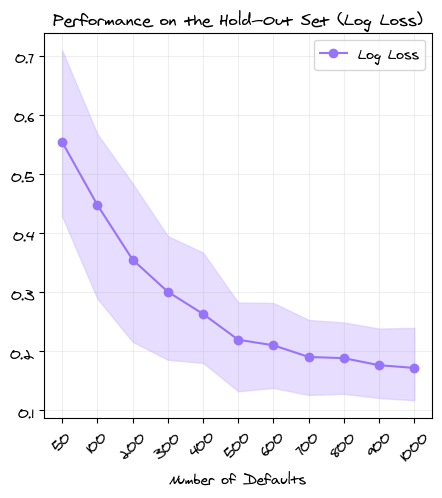

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from matplotlib import pyplot as plt

# Store the results in a dictionary
eval_results = {"classifier": [], "log_loss": [], "ci_lower": [], "ci_upper": []}

# Set up KFold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for clf_name, classifier in classifiers.items():
    eval_results["classifier"].append(clf_name)

    # Perform custom k-fold sampling and calculate log-loss scores
    log_loss_scores = []

    for _, fold_ix in kf.split(holdout_set[features], holdout_set[target]):
        X_trn = X.loc[ix_test].iloc[fold_ix]
        y_trn = y.loc[ix_test].iloc[fold_ix]

        # Calculate log-loss for the current bootstrap sample
        y_pred_proba = classifier.predict_proba(X_trn)
        current_log_loss = log_loss(y_trn, y_pred_proba)
        log_loss_scores.append(current_log_loss)

    # Calculate mean and standard deviation of log-loss scores
    mean_log_loss = np.mean(log_loss_scores)
    std_log_loss = np.std(log_loss_scores)

    ci_lower = min(log_loss_scores)
    ci_upper = max(log_loss_scores)

    eval_results["ci_lower"].append(ci_lower)
    eval_results["ci_upper"].append(ci_upper)
    eval_results["log_loss"].append(mean_log_loss)

figure = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(
    eval_results["classifier"],
    eval_results["log_loss"],
    marker="o",
    color="#9775fa",
    label="Log Loss",
)
plt.fill_between(
    eval_results["classifier"],
    eval_results["ci_lower"],
    eval_results["ci_upper"],
    color="#d0bfff",
    alpha=0.5,
)

# Customize the plot
plt.xlabel("Number of Defaults")
plt.title("Performance on the Hold-Out Set (Log Loss)")
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.legend()
plt.show()

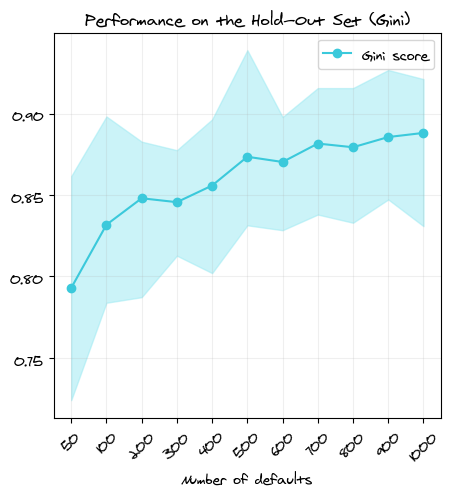

In [16]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

# Store the results in a dictionary
eval_results = {"classifier": [], "gini": [], "ci_lower": [], "ci_upper": []}

# Set up KFold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for clf_name, classifier in classifiers.items():
    eval_results["classifier"].append(clf_name)

    # Perform cross-validation and calculate gini scores
    gini_scores = []

    for _, fold_ix in kf.split(holdout_set[features], holdout_set[target]):
        X_trn = X.loc[ix_test].iloc[fold_ix]
        y_trn = y.loc[ix_test].iloc[fold_ix]

        # Calculate log-loss for the current sample
        y_pred_proba = classifier.predict_proba(X_trn)[:, 1]
        current_gini = roc_auc_score(y_trn, y_pred_proba) * 2 - 1  # type: ignore
        gini_scores.append(current_gini)

    # Calculate mean and standard deviation of gini scores
    mean_gini = np.mean(gini_scores)
    std_gini = np.std(gini_scores)

    ci_lower = min(gini_scores)
    ci_upper = max(gini_scores)

    eval_results["ci_lower"].append(ci_lower)
    eval_results["ci_upper"].append(ci_upper)
    eval_results["gini"].append(mean_gini)

figure = plt.figure(figsize=(5, 5), dpi=100)
plt.plot(
    eval_results["classifier"],
    eval_results["gini"],
    marker="o",
    color="#3bc9db",
    label="Gini score",
)
plt.fill_between(
    eval_results["classifier"],
    eval_results["ci_lower"],
    eval_results["ci_upper"],
    color="#99e9f2",
    alpha=0.5,
)

# Customize the plot
plt.xlabel("Number of defaults")
plt.title("Performance on the Hold-Out Set (Gini)")
plt.xticks(rotation=45)
plt.grid(alpha=0.2)
plt.legend()
plt.show()

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Class weights</span>

In [107]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.utils import class_weight

# Define fractions to rebalance the dataset
fractions = [0.09, 0.19, 0.35, 0.49, 0.61, 0.69]
datasets = create_imbalanced_datasets_with_prefix(X, y, fractions, prefix="")

low_default_dataset = datasets[datasets["name"] == "1%"].copy()
X_resampled, y_resampled = low_default_dataset[features], low_default_dataset[target]


def evaluate_model(model, X_train, y_train, X_test, y_test, sample_weights=None):
    if sample_weights is not None:
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

    print("\nTest scores:")
    predictions_test = model.predict_proba(X_test)[:, 1]
    gini_test = roc_auc_score(y_test, predictions_test) * 2 - 1  # type: ignore
    log_loss_test = log_loss(y_test, predictions_test)
    print(f"Gini test score: {gini_test:.2%}")
    print(f"Log loss test score: {log_loss_test:.2%}")


# Sklearn class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight="balanced", y=y_resampled
)

"""
Weighted exogenous sampling maximum-likelihood estimator:
An alternative procedure is to weight the data to compensate for differences in the sample
(y¯) and population (τ) fractions of ones induced by choice-based sampling
"""

# Manual upsampling from https://johaupt.github.io/blog/downsampling_recalibration.html
# Based on King and Zeng (2001): https://gking.harvard.edu/files/0s.pdf
b = y_resampled.mean()
original_ratio = b / (1 - b)
target_dr = 0.15
target_ratio = target_dr / (1 - target_dr)
weight = original_ratio / target_ratio
sample_weights = np.ones(y_resampled.shape[0], dtype="float") * weight

# Initialize models
xgb_model_sw = xgb.XGBClassifier()
xgb_model_cw = xgb.XGBClassifier()
xgb_model = xgb.XGBClassifier()

# Evaluate models
print("With target sample weight:")
print("--------------------")
evaluate_model(
    xgb_model_sw,
    X_resampled,
    y_resampled,
    X.loc[ix_test],
    y.loc[ix_test],
    sample_weights,
)

print("\nWith 1:1 class weight:")
print("--------------------")
evaluate_model(
    xgb_model_cw,
    X_resampled,
    y_resampled,
    X.loc[ix_test],
    y.loc[ix_test],
    classes_weights,
)

print("\nNo sample weight:")
print("-----------------")
evaluate_model(xgb_model, X_resampled, y_resampled, X.loc[ix_test], y.loc[ix_test])

With target sample weight:
--------------------

Test scores:
Gini test score: 87.71%
Log loss test score: 26.94%

With 1:1 class weight:
--------------------

Test scores:
Gini test score: 80.56%
Log loss test score: 36.00%

No sample weight:
-----------------

Test scores:
Gini test score: 84.18%
Log loss test score: 39.73%



With target weights
Gini test score: 87.71%
Log loss test score: 26.94%

With 1:1 weights
Gini test score: 80.56%
Log loss test score: 36.00%

No weights
Gini test score: 84.18%
Log loss test score: 39.73%


/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_23159/2544449181.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


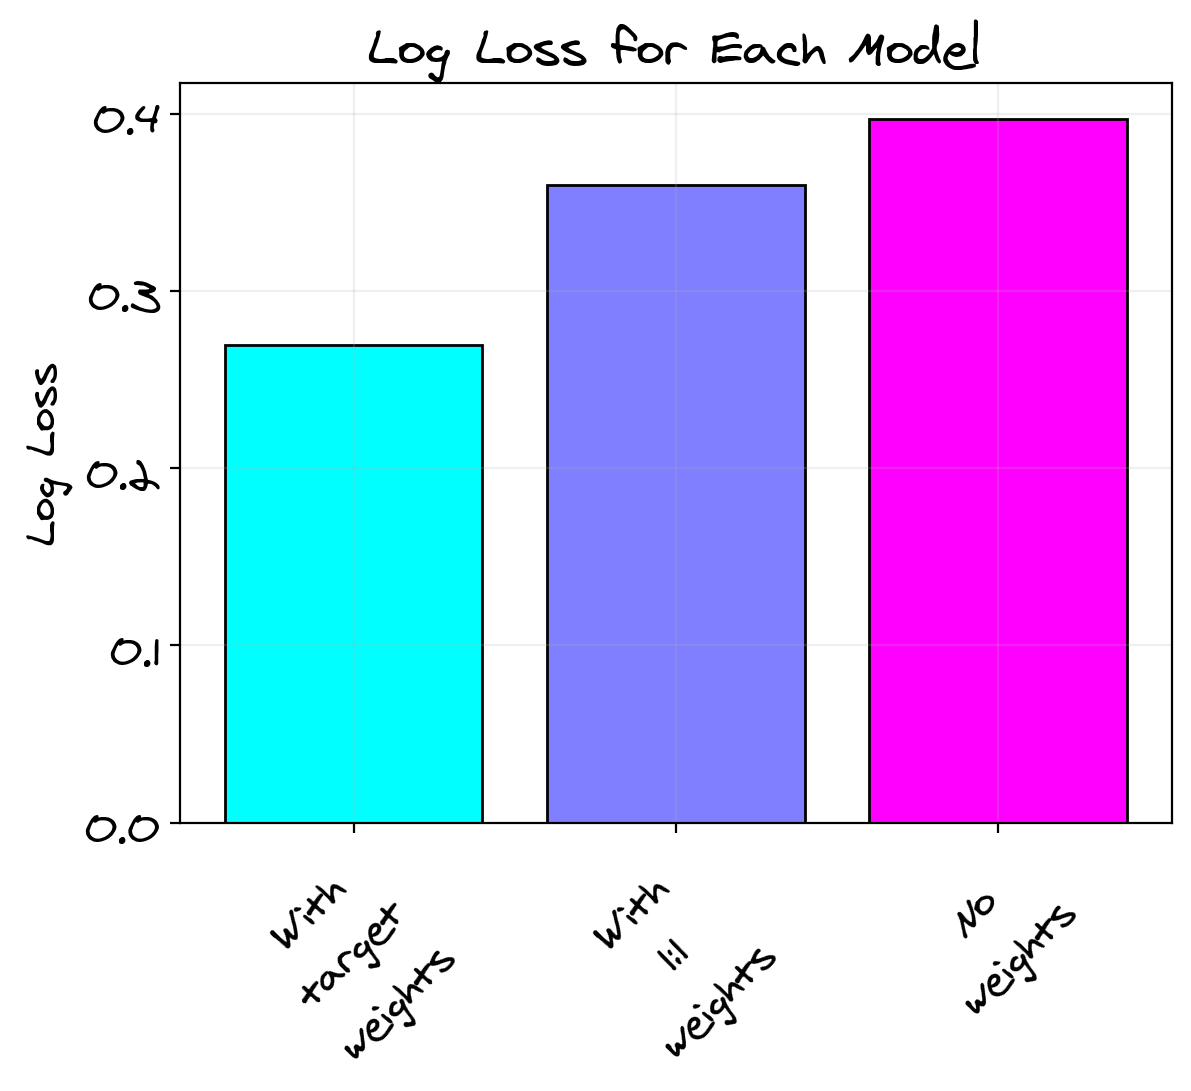

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_23159/2544449181.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


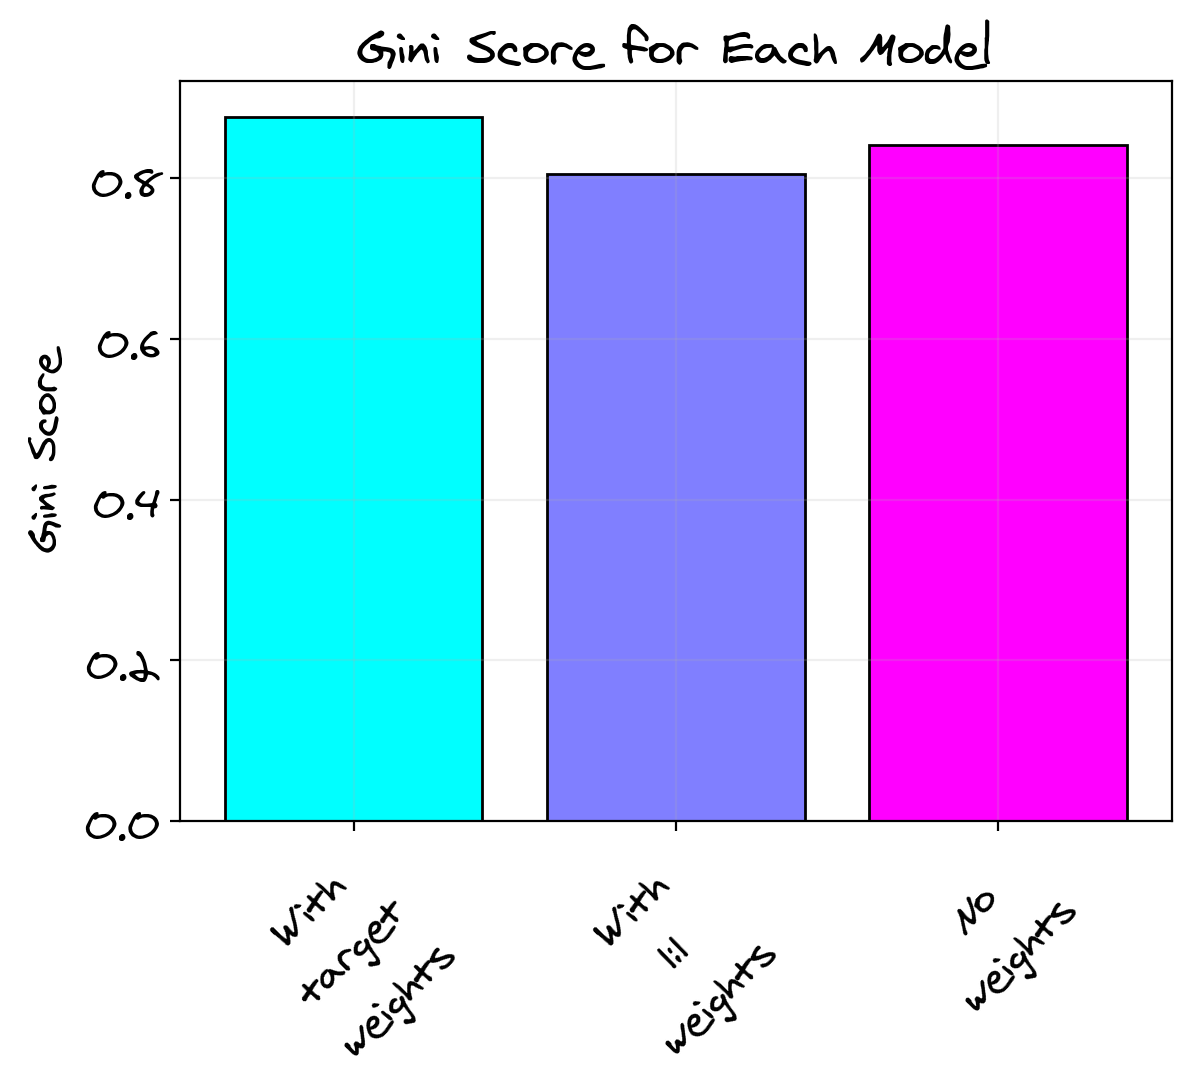

In [95]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np

# Store the results in a dictionary
eval_results = {"classifier": [], "log_loss": [], "gini": []}

# Evaluate models
classifiers = [xgb_model_sw, xgb_model_cw, xgb_model]
classifier_names = ["With target weights", "With 1:1 weights", "No weights"]

for model, name in zip(classifiers, classifier_names):
    print("\n" + name)
    predictions_test = model.predict_proba(X.loc[ix_test])[:, 1]

    # Gini calculation
    gini_test = roc_auc_score(y.loc[ix_test], predictions_test) * 2 - 1  # type: ignore
    print(f"Gini test score: {gini_test:.2%}")

    # Log-loss calculation
    log_loss_test = log_loss(y.loc[ix_test], predictions_test)
    print(f"Log loss test score: {log_loss_test:.2%}")

    # Store the results in the dictionary
    eval_results["classifier"].append(name)
    eval_results["log_loss"].append(log_loss_test)
    eval_results["gini"].append(gini_test)

plt.rcParams["font.size"] = 15
cool_cmap = plt.get_cmap("cool")
colors = cool_cmap(np.linspace(0, 1, len(eval_results["classifier"])))
# Plot for log-loss
fig, ax = plt.subplots(dpi=100)
colors = cool_cmap(np.linspace(0, 1, len(eval_results["classifier"])))
ax.bar(
    eval_results["classifier"],
    eval_results["log_loss"],
    color=colors,
    edgecolor="black",
)
ax.set_xticklabels(
    [label.replace(" ", "\n") for label in eval_results["classifier"]],
    rotation=45,
    ha="center",
)
ax.set_ylabel("Log Loss")
ax.set_title("Log Loss for Each Model")
plt.grid(alpha=0.2)
plt.show()

# Plot for Gini
fig, ax = plt.subplots()
colors = cool_cmap(np.linspace(0, 1, len(eval_results["classifier"])))
ax.bar(
    eval_results["classifier"], eval_results["gini"], color=colors, edgecolor="black"
)
ax.set_xticklabels(
    [label.replace(" ", "\n") for label in eval_results["classifier"]],
    rotation=45,
    ha="center",
)
ax.set_ylabel("Gini Score")
ax.set_title("Gini Score for Each Model")
plt.grid(alpha=0.2)
plt.show()

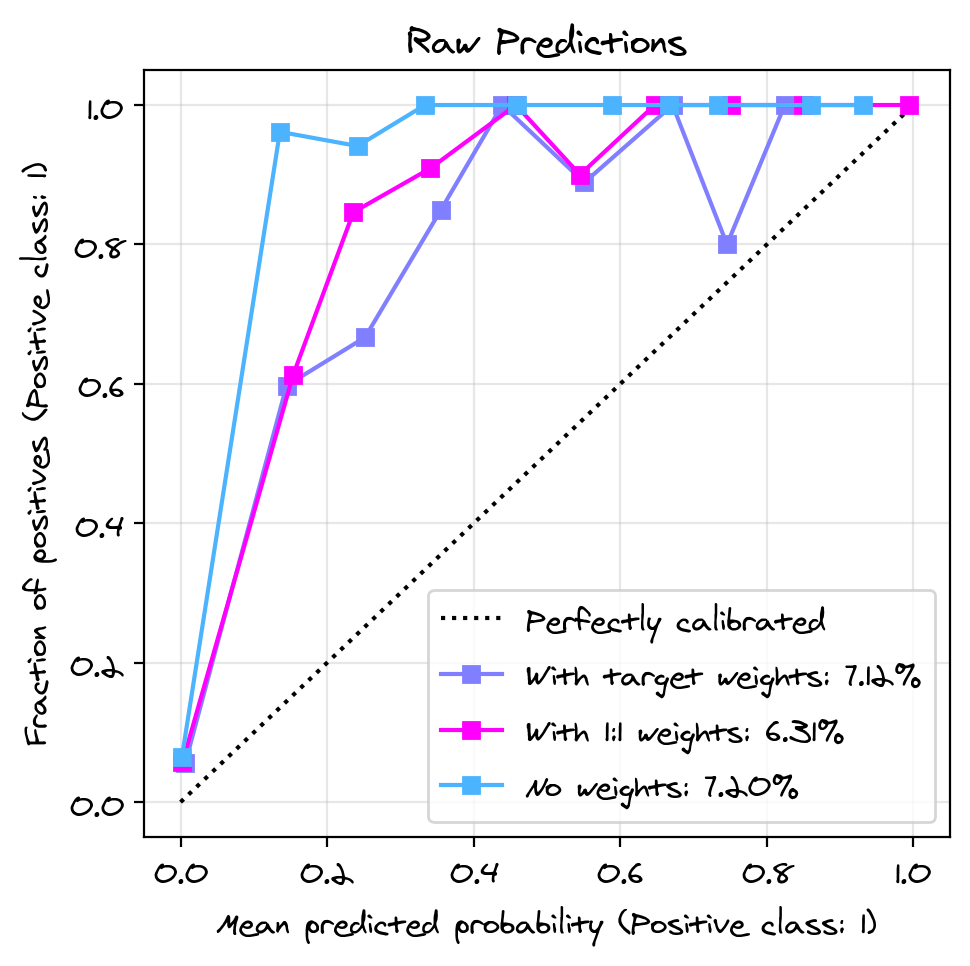

In [96]:
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

%config InlineBackend.figure_format = 'retina'

# from https://johaupt.github.io/blog/downsampling_recalibration.html


def recalibrate(p, w):
    return p / (p + ((1 - p) / w))


predictions_sw = xgb_model_sw.predict_proba(X.loc[ix_test])[:, 1]
predictions_cw = xgb_model_cw.predict_proba(X.loc[ix_test])[:, 1]
predictions = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

classifier_names = ["With target weights", "With 1:1 weights", "No weights"]

model_predictions = [
    (classifier_names[0], predictions_sw),
    (classifier_names[1], predictions_cw),
    (classifier_names[2], predictions),
]

plt.rcParams["font.size"] = 11
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
colors = (
    plt.get_cmap("cool")(0.5),
    plt.get_cmap("cool")(1.0),
    plt.get_cmap("cool")(0.3),
    plt.get_cmap("cool")(0.7),
    plt.get_cmap("cool")(0.85),
)
for i, (model_name, predictions) in enumerate(model_predictions):
    brier_score = brier_score_loss(y.loc[ix_test], predictions)
    CalibrationDisplay.from_predictions(
        y.loc[ix_test].values.reshape(-1, 1),
        predictions,
        ax=ax,
        name=f"{model_name}: {brier_score:.2%}",
        color=colors[i],
        n_bins=10,
    )
plt.title("Raw Predictions")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

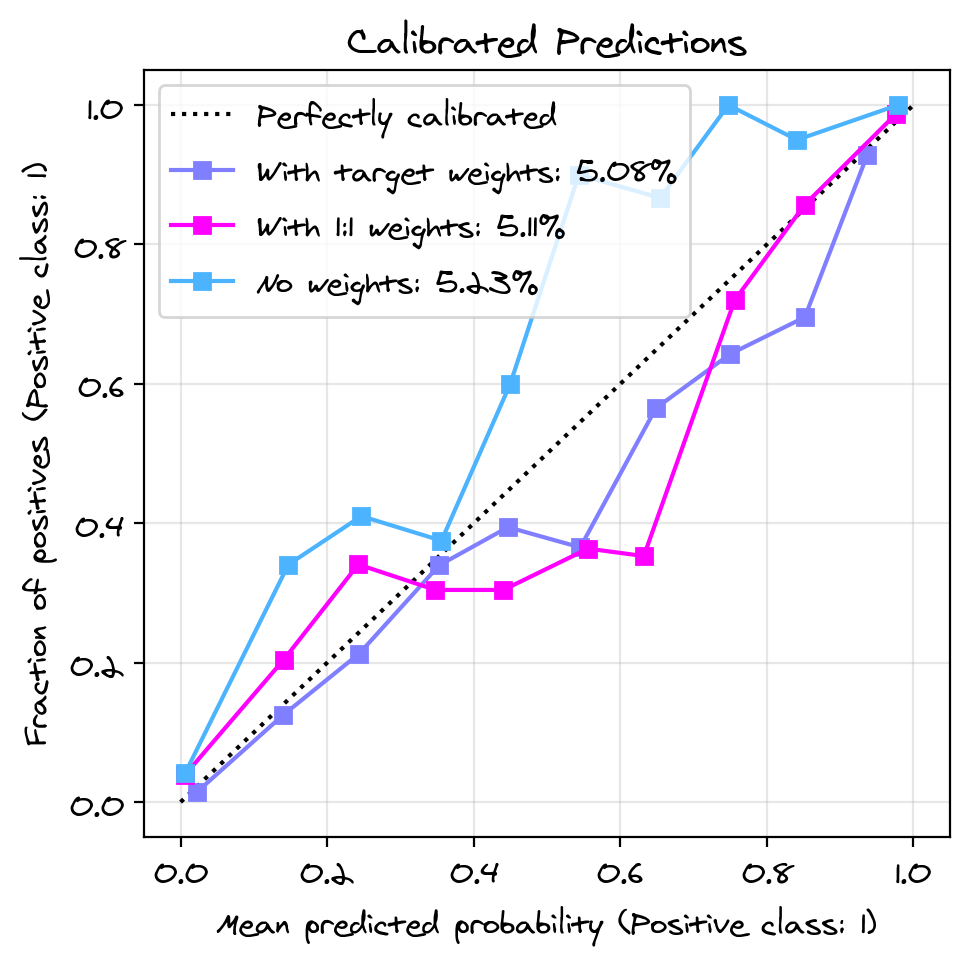

In [97]:
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

%config InlineBackend.figure_format = 'retina'

# from https://johaupt.github.io/blog/downsampling_recalibration.html


def recalibrate(p, w):
    return p / (p + ((1 - p) / w))


predictions_sw_rec = recalibrate(predictions_sw, 1 / weight)
predictions_cw_rec = recalibrate(predictions_cw, 1 / weight)
predictions = xgb_model.predict_proba(X.loc[ix_test])[:, 1]
predictions_rec = recalibrate(predictions, 1 / weight)

model_predictions = [
    (classifier_names[0], predictions_sw_rec),
    (classifier_names[1], predictions_cw_rec),
    (classifier_names[2], predictions_rec),
]

plt.rcParams["font.size"] = 11
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
colors = (
    plt.get_cmap("cool")(0.5),
    plt.get_cmap("cool")(1.0),
    plt.get_cmap("cool")(0.3),
    plt.get_cmap("cool")(0.7),
    plt.get_cmap("cool")(0.85),
)
for i, (model_name, predictions) in enumerate(model_predictions):
    brier_score = brier_score_loss(y.loc[ix_test], predictions)
    CalibrationDisplay.from_predictions(
        y.loc[ix_test].values.reshape(-1, 1),
        predictions,
        ax=ax,
        name=f"{model_name}: {brier_score:.2%}",
        color=colors[i],
        n_bins=10,
    )
plt.title("Calibrated Predictions")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()